In [1]:
import numpy as np

def load_glove(path, dim=100):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove = load_glove(r"C:\Users\ashis\Downloads\glove.6B\glove.6B.100d.txt", 100)
print("Loaded words:", len(glove))


Loaded words: 400000


In [2]:
from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

def word_similarity(w1, w2, model):
    return cosine_sim(model[w1], model[w2])


word_similarity("king", "queen", glove)
word_similarity("car", "banana", glove)


0.14861871

In [3]:
# king - man + woman ≈ queen

def analogy(a, b, c, model, top_n=5):
    vec = model[a] - model[b] + model[c]
    scores = {}

    for word, emb in model.items():
        scores[word] = cosine_sim(vec, emb)

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

analogy("king", "man", "woman", glove)


[('king', 0.85518366),
 ('queen', 0.7834413),
 ('monarch', 0.6933802),
 ('throne', 0.6833111),
 ('daughter', 0.6809082)]

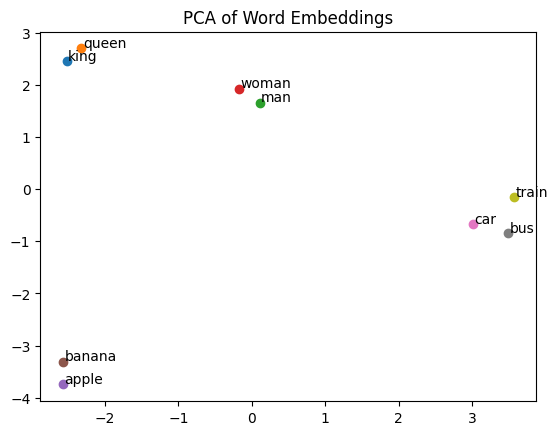

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = ["king","queen","man","woman","apple","banana","car","bus","train"]
vectors = np.array([glove[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

plt.figure()
for i, word in enumerate(words):
    plt.scatter(coords[i,0], coords[i,1])
    plt.text(coords[i,0]+0.02, coords[i,1]+0.02, word)
plt.title("PCA of Word Embeddings")
plt.show()


In [5]:
# def cosine_sim(a, b):
#     return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [6]:
# print("GloVe similarity (king, queen):",
#       cosine_sim(glove["king"], glove["queen"]))


In [7]:
# def glove_analogy(a, b, c, model, top_n=5):
#     target = model[a] - model[b] + model[c]
#     scores = {}

#     for word, vec in model.items():
#         scores[word] = cosine_sim(target, vec)

#     return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

# print(glove_analogy("king", "man", "woman", glove))


In [8]:
# def word2vec_lookup(word, model):
#     if word not in model:
#         raise KeyError("OOV word (Word2Vec limitation)")
#     return model[word]


In [9]:
# try:
#     word2vec_lookup("languaging", glove)
# except KeyError:
#     print("Word2Vec-style model: OOV ❌")


In [10]:
# def char_ngrams(word, n=3):
#     word = f"<{word}>"
#     return [word[i:i+n] for i in range(len(word)-n+1)]


In [11]:
# from collections import defaultdict

# subword_vectors = defaultdict(list)

# for word, vec in glove.items():
#     for ng in char_ngrams(word):
#         subword_vectors[ng].append(vec)

# # Average subword vectors
# subword_vectors = {
#     ng: np.mean(vs, axis=0)
#     for ng, vs in subword_vectors.items()
# }


In [12]:
# def fasttext_like_embedding(word):
#     ngrams = char_ngrams(word)
#     vectors = [subword_vectors[ng]
#                for ng in ngrams if ng in subword_vectors]

#     if not vectors:
#         raise ValueError("No subwords found")

#     return np.mean(vectors, axis=0)


In [13]:
# # Known word
# print("FastText-style (language):",
#       fasttext_like_embedding("language")[:5])

# # OOV word
# print("FastText-style (languaging):",
#       fasttext_like_embedding("languaging")[:5])


In [14]:
# sim = cosine_sim(
#     fasttext_like_embedding("language"),
#     fasttext_like_embedding("languaging")
# )

# print("Similarity(language, languaging):", sim)


In [15]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# words = ["language", "languaging", "king", "queen"]
# vectors = [
#     fasttext_like_embedding(w) if w not in glove else glove[w]
#     for w in words
# ]

# coords = PCA(n_components=2).fit_transform(vectors)

# plt.figure()
# for i, w in enumerate(words):
#     plt.scatter(coords[i,0], coords[i,1])
#     plt.text(coords[i,0]+0.02, coords[i,1]+0.02, w)

# plt.title("FastText-style OOV Handling (No gensim)")
# plt.show()


In [16]:
import gensim.downloader as api
from gensim.models.word2vec import Text8Corpus

path = api.load("text8", return_path=True)
print("Text8 path:", path)

corpus = Text8Corpus(path)


Text8 path: C:\Users\ashis/gensim-data\text8\text8.gz


In [17]:
from tqdm import tqdm
from gensim.models.callbacks import CallbackAny2Vec

class TqdmCallback(CallbackAny2Vec):
    def __init__(self, epochs):
        self.pbar = tqdm(total=epochs, desc="Training")

    def on_epoch_end(self, model):
        self.pbar.update(1)

    def on_train_end(self, model):
        self.pbar.close()


In [18]:
from gensim.models import Word2Vec

w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=10,
    callbacks=[TqdmCallback(epochs=10)]
)


Training: 100%|██████████| 10/10 [03:07<00:00, 18.74s/it]


In [19]:
from gensim.models import FastText

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    epochs=10,
    callbacks=[TqdmCallback(epochs=10)]
)


Training: 100%|██████████| 10/10 [13:11<00:00, 79.17s/it]


In [20]:
print("Word2Vec similarity:",
      w2v.wv.similarity("king", "queen"))

print("FastText similarity:",
      ft.wv.similarity("king", "queen"))


Word2Vec similarity: 0.677503
FastText similarity: 0.6983721


In [ ]:
##Conclusion
## FastText achieved slightly higher semantic similarity scores due to its incorporation of subword information, 
# while Word2Vec demonstrated strong baseline performance on frequent words

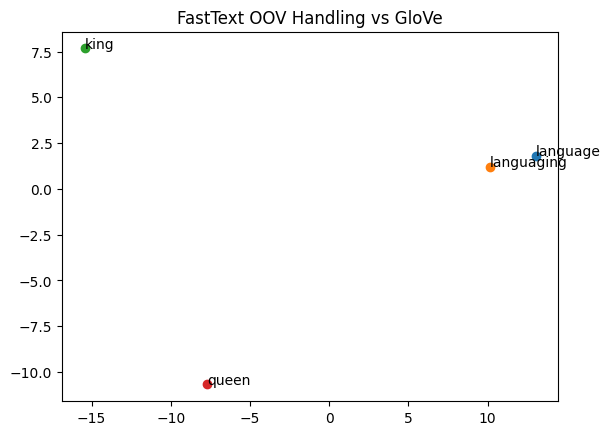

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = ["language", "languaging", "king", "queen"]
vectors = [
    ft.wv[w] if w in ft.wv else glove[w]
    for w in words
]

coords = PCA(n_components=2).fit_transform(vectors)

plt.figure()
for i, w in enumerate(words):
    plt.scatter(coords[i,0], coords[i,1])
    plt.text(coords[i,0]+0.02, coords[i,1]+0.02, w)

plt.title("FastText OOV Handling vs GloVe")
plt.show()
